DHS Data is downloaded from the DHS.
- Household recode data and Goegraphic datasets for each country are downloaded
- .DCF file within the data provides the attributes and line numbers to be used to read wealth and cluster information as required.


In [10]:
import pandas as pd
import numpy as np

file_name = 'data/DHS/RWHR61FL.DAT'
cluster_file = 'data/DHS/rwanda_clusters_location.csv'
cluster_all = []
wealth_all = []
with open(file_name) as f:
    for line in f:
        cluster = int(line[15:23])
        wealth = int(line[230:238]) / 100000.0
        cluster_all.append(cluster)
        wealth_all.append(wealth)

df = pd.DataFrame({'cluster': cluster_all, 'wlthindf': wealth_all})
cluster_avg_asset = df.groupby('cluster')['wlthindf'].median().reset_index()
df_location = pd.read_csv(cluster_file)[['DHSCLUST', 'LATNUM', 'LONGNUM']]
result = cluster_avg_asset.merge(df_location, how='inner', left_on='cluster', right_on='DHSCLUST')[['cluster', 'wlthindf', 'LATNUM', 'LONGNUM']]
result.rename(columns={'LATNUM': 'latitude', 'LONGNUM':'longitude'}, inplace=True)
result.to_csv('intermediate_files/Rwanda_cluster_avg_asset_2010.csv', index=False)
result.head()

,cluster,wlthindf,latitude,longitude
0,1,-0.531405,-2.532818,29.684726
1,2,-0.409830,-1.833858,30.310689
2,3,-0.478115,-1.888155,29.478298
3,4,-0.435960,-2.366763,30.521692
4,5,-0.449480,-2.171266,30.018541


# Nightlight Data
Download high resolution .tiff nightlight image from NOAA using the Link

In [ ]:
import wget

night_image_url = 'https://ngdc.noaa.gov/eog/data/web_data/v4composites/F182010.v4.tar'
wget.download(night_image_url)

In [9]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
from io import StringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np


def read_raster(raster_file):
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)


# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

raster_file = 'data/nighttime_image/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format - see https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html
np.savez('intermediate_files/nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

In [11]:
# get nightlight features for each cluster
def get_nightlight_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = bands_data[j, i, 0]
            luminosity_100.append(luminosity)
    luminosity_100 = np.asarray(luminosity_100)
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    return pd.Series({'id': idx, 'max_': max_, 'min_': min_, 'mean_': mean_, 
                      'median_': median_, 'std_': std_, 'wealth': wealth, 'clust_long': x, 'clust_lat': y})


clusters = pd.read_csv('intermediate_files/rwanda_cluster_avg_asset_2010.csv')
data_all = clusters.apply(lambda x: get_nightlight_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)
data_all.to_csv('intermediate_files/DHS_nightlights1.csv', index=None)
data_all.head()


,id,max_,min_,mean_,median_,std_,wealth,clust_long,clust_lat
0,1.0,6.0,0.0,0.06,0.0,0.596992,-0.531405,29.684726,-2.532818
1,2.0,0.0,0.0,0.00,0.0,0.000000,-0.409830,30.310689,-1.833858
2,3.0,0.0,0.0,0.00,0.0,0.000000,-0.478115,29.478298,-1.888155
3,4.0,0.0,0.0,0.00,0.0,0.000000,-0.435960,30.521692,-2.366763
4,5.0,0.0,0.0,0.00,0.0,0.000000,-0.449480,30.018541,-2.171266


(0, 50)

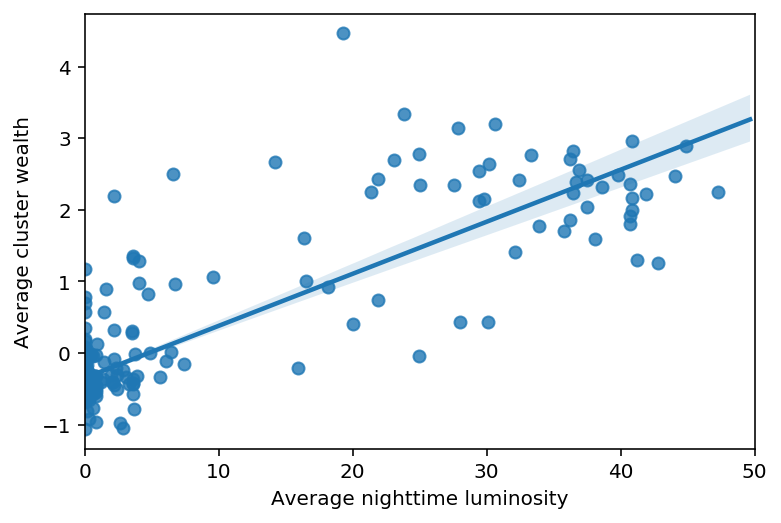

In [7]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="mean_", y="wealth", data=data_all)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.xlim([0, 50])

In [8]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = pd.read_csv('intermediate_files/DHS_nightlights.csv')
data_all = data_all[['max_', 'min_', 'mean_', 'median_', 'std_', 'wealth']].values
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model: {:.3f}'.format(np.max(final)))

R^2 of the best model: 0.752
